# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform


# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K

# SETTINGS

## Global

In [2]:
# Settings
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy=False

#set size of validation set and test set in percentage
validation_size = 10
test_size = 10

# Generators Paramenters
batch_size = 32
img_size = (224,224)

## Dataset Parameters

In [3]:
# Dataset Root Path
dataset_path = "../input/rx-covid-and-gan/COVID-19_Radiography_Dataset+GAN/"

# Folder Paths
covid_path = dataset_path + "/COVID/images"
lungOpacity_path = dataset_path + "/Lung_Opacity/images"
normal_path = dataset_path + "/Normal/images"
viralPneumonia_path = dataset_path + "/Viral Pneumonia/images"

# LABELS LOCAL Array
#labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
labels = ['COVID', 'Normal', 'Viral Pneumonia']

# DATA PREPARATION

In [4]:
# Generate Filename list
def filename_list():

    if toy :
        random.seed(100)
        filenames = random.sample(os.listdir(covid_path), 200) + random.sample(os.listdir(lungOpacity_path), 200) + random.sample(os.listdir(normal_path), 200) + random.sample(os.listdir(viralPneumonia_path), 200)
    else :
       #filenames = os.listdir(covid_path) + os.listdir(lungOpacity_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)
        filenames = os.listdir(covid_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)

    return filenames

In [5]:
def dataframe_generation(files):
    
    categories = []
    for filename in files:
        category = filename.split('-')[0]
        if category == labels[0]:
            categories.append(str(0))
        elif category == labels[1]:
            categories.append(str(1))
        elif category == labels[2]:
            categories.append(str(2))
        #elif category == labels[3]:
         #   categories.append(str(3))

    for i in range(len(files)):
        if labels[0] in files[i]:
            files[i] = os.path.join(covid_path, files[i])
        #elif labels[1] in files[i]:
            #files[i] = os.path.join(lungOpacity_path, files[i])
        elif labels[1] in files[i]:
            files[i] = os.path.join(normal_path, files[i])
        elif labels[2] in files[i]:
            files[i] = os.path.join(viralPneumonia_path, files[i])
    
    df = pd.DataFrame({
        'filename': files,
        'category': categories
    })

    return df

## Generate Dataset

In [6]:
filenames = filename_list()
dataset_df = dataframe_generation(filenames)

dataset_df.head()

,filename,category
0,../input/rx-covid-and-gan/COVID-19_Radiography...,0
1,../input/rx-covid-and-gan/COVID-19_Radiography...,0
2,../input/rx-covid-and-gan/COVID-19_Radiography...,0
3,../input/rx-covid-and-gan/COVID-19_Radiography...,0
4,../input/rx-covid-and-gan/COVID-19_Radiography...,0


In [7]:
def read_img(id):
    """
    Read image by it's id
    """
    file=id
    im=cv2.imread(file)
    return im

def draw_sample_images(dataframe, ncols, labels):

        ncols=ncols
        n_rows = len(labels)

        f, ax = plt.subplots(nrows=n_rows,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=labels
        
        for label in range(n_rows):
            i=i+1
            samples = dataframe[dataframe["category"].astype(int) == label].filename.sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

In [8]:
def plot_data_distribution(dataframe):
    y = np.bincount(dataframe.category)
    x = labels
    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(x, y,width=0.7)
    ax.set_xticks(x)
    ax.set_aspect('auto')
    plt.show()

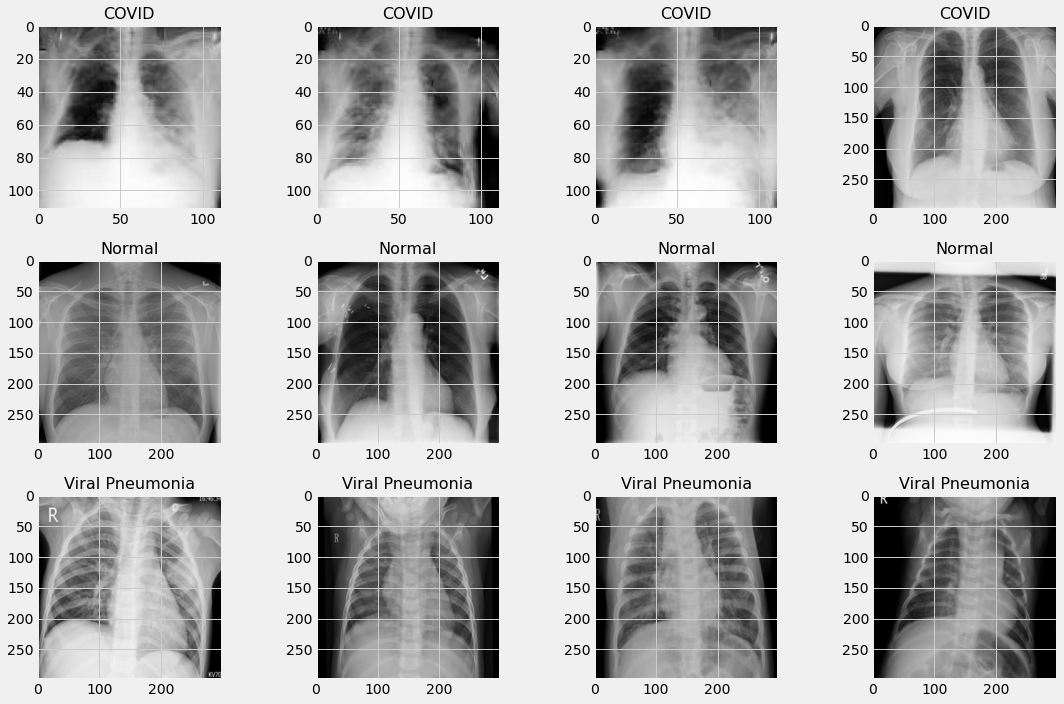

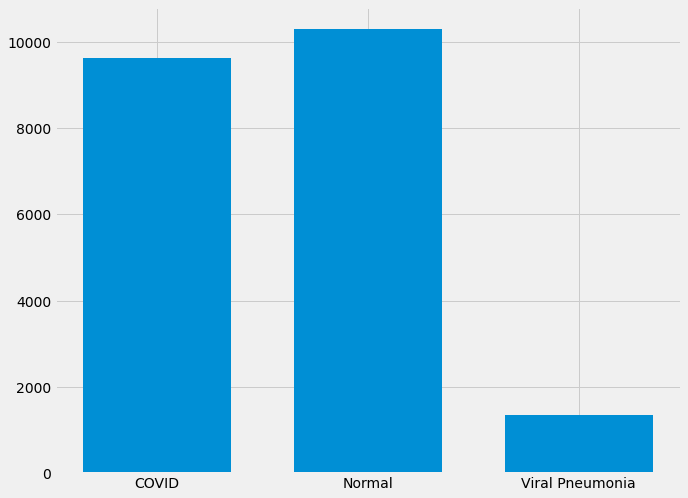

In [9]:
draw_sample_images(dataset_df, 4, labels)
plot_data_distribution(dataset_df)

## Split in Train, Validation and Test

In [12]:
def sets_split(dataframe):
    x_1_split = (validation_size + test_size)/100
    x_2_split = round(test_size / (validation_size + test_size), 2)

    train_df, valTest_df = train_test_split(dataframe, test_size=x_1_split, random_state=24)
    val_df, test_df = train_test_split(valTest_df, test_size=x_2_split, random_state=24)

    return train_df, val_df, test_df

In [13]:
train, validation, test = sets_split(dataset_df)

## Generators

In [14]:
_datagen = ImageDataGenerator(
            #rotation_range=15,
            #rescale=1./255,
            #shear_range=0.1,
            #zoom_range=0.2,
            #horizontal_flip=True,
            #width_shift_range=0.1,
            #height_shift_range=0.1   
            )

#_test_datagen=ImageDataGenerator(rescale=1./255)
_test_datagen=ImageDataGenerator()

In [15]:
train_generator = _datagen.flow_from_dataframe(
            dataframe=train,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)
print('Train generator created')

Found 17002 validated image filenames belonging to 3 classes.
Train generator created


In [16]:
val_generator = _test_datagen.flow_from_dataframe(
            dataframe=validation,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)    
print('Validation generator created')

Found 2125 validated image filenames belonging to 3 classes.
Validation generator created


In [17]:
test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test,
            x_col="filename",
            y_col=None,
            class_mode=None,
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            color_mode="rgb",
            target_size=img_size)     
print('Test generator created')

Found 2126 validated image filenames.
Test generator created


# MODEL GENERATION

## Metrics Aux Functions

In [18]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Creation

In [19]:
def create_model(size):
        base_model = ResNet50(input_shape= (size,size,3), weights="imagenet", include_top=False)
        
        for layer in base_model.layers:
            layer.trainable = False

        x=base_model.output
        x=GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        x= Dropout(0.5)(x)
        out=Dense(3,activation='softmax')(x)

        model=Model(inputs=base_model.input,outputs=out) 
            
        model.compile(optimizer= Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])
                  
        return model

In [20]:
model = create_model(224)
model.summary()

2022-06-24 12:48:09.202621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 12:48:09.279660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 12:48:09.280482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 12:48:09.282382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

## Define Trainer

In [21]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


class AccLossPlotter(Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class
    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """

    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph


    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_accuracy'))
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            #plt.axis([0,100,0,1])
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            #plt.axis([0,100,0,5])
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch
    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        #plt.show()
        #plt.figure()

        #plt.title(self.title)
        
        

    def on_train_begin(self, logs={}):
        pass

    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = self.Y_val
        max_y=max_y[:len(max_pred)] 
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        plt.colorbar()
                                                                                                         
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        #plt.draw()
        plt.show()
        plt.pause(0.001)

In [22]:
plotter = ConfusionMatrixPlotter(X_val=val_generator, classes=labels, Y_val=validation.category.values.astype(int))
epoch_loss = AccLossPlotter()

In [23]:
def train(model, train_data, val_data, toy):
        """
        Train the model
        """
        if toy:
            epochs=3

        else:
            epochs=100
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=5 , restore_best_weights=True)

        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_loss'
                                        ,mode='min'
                                        ,verbose=1
                                        ,save_best_only=True)
        # Train
        training = model.fit(train_data, 
                            validation_data = val_data, 
                            epochs = epochs, 
                            verbose = 1,
                            batch_size = batch_size,
                            callbacks=[earlystopper, checkpointer, plotter, epoch_loss])
        
        print("Trained")
                            
        return training

2022-06-24 12:48:14.185998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-24 12:48:18.608010: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


532/532 [==============================] - 121s 209ms/step - loss: 0.3508 - accuracy: 0.8703 - f1_m: 0.8656 - precision_m: 0.8809 - recall_m: 0.8519 - val_loss: 0.1851 - val_accuracy: 0.9379 - val_f1_m: 0.9372 - val_precision_m: 0.9380 - val_recall_m: 0.9364

Epoch 00001: val_loss improved from inf to 0.18512, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


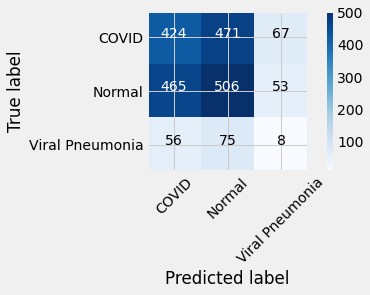

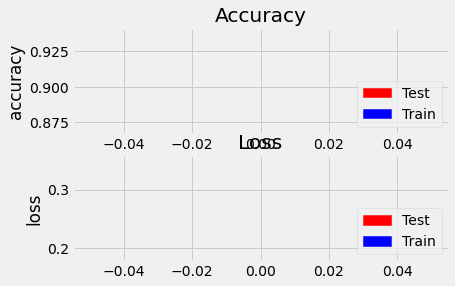

Epoch 2/100
532/532 [==============================] - 64s 120ms/step - loss: 0.2132 - accuracy: 0.9293 - f1_m: 0.9285 - precision_m: 0.9323 - recall_m: 0.9249 - val_loss: 0.1406 - val_accuracy: 0.9525 - val_f1_m: 0.9526 - val_precision_m: 0.9533 - val_recall_m: 0.9520

Epoch 00002: val_loss improved from 0.18512 to 0.14064, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


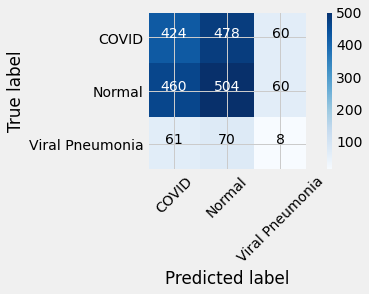

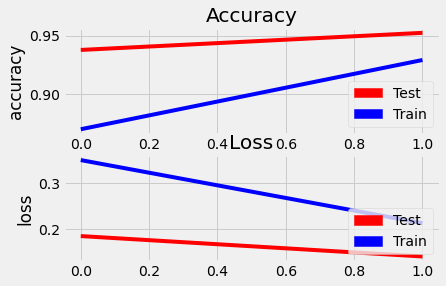

Epoch 3/100
532/532 [==============================] - 63s 118ms/step - loss: 0.1735 - accuracy: 0.9448 - f1_m: 0.9441 - precision_m: 0.9464 - recall_m: 0.9418 - val_loss: 0.1198 - val_accuracy: 0.9586 - val_f1_m: 0.9594 - val_precision_m: 0.9608 - val_recall_m: 0.9580

Epoch 00003: val_loss improved from 0.14064 to 0.11985, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


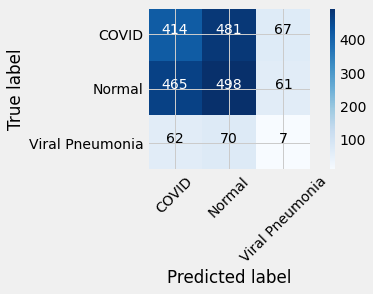

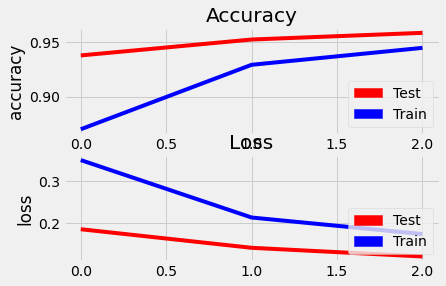

Epoch 4/100
532/532 [==============================] - 64s 121ms/step - loss: 0.1510 - accuracy: 0.9530 - f1_m: 0.9532 - precision_m: 0.9553 - recall_m: 0.9512 - val_loss: 0.1082 - val_accuracy: 0.9619 - val_f1_m: 0.9606 - val_precision_m: 0.9608 - val_recall_m: 0.9604

Epoch 00004: val_loss improved from 0.11985 to 0.10823, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


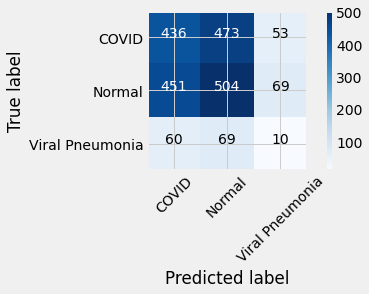

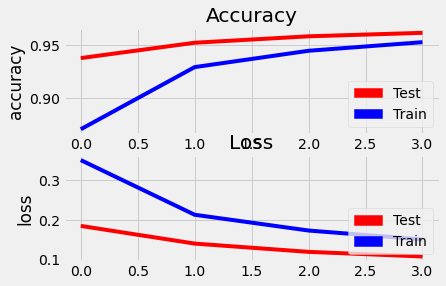

Epoch 5/100
532/532 [==============================] - 63s 119ms/step - loss: 0.1321 - accuracy: 0.9592 - f1_m: 0.9591 - precision_m: 0.9605 - recall_m: 0.9577 - val_loss: 0.0995 - val_accuracy: 0.9638 - val_f1_m: 0.9627 - val_precision_m: 0.9631 - val_recall_m: 0.9623

Epoch 00005: val_loss improved from 0.10823 to 0.09955, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


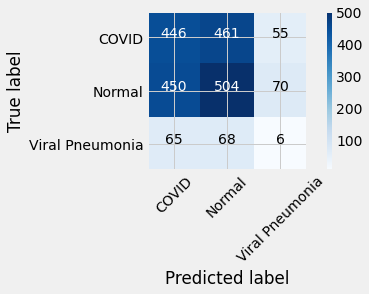

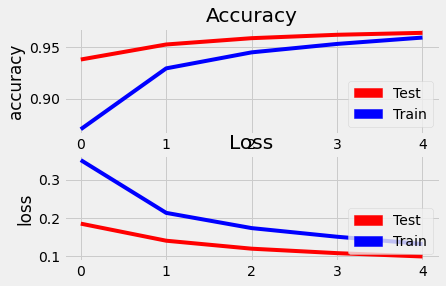

Epoch 6/100
532/532 [==============================] - 61s 115ms/step - loss: 0.1211 - accuracy: 0.9639 - f1_m: 0.9635 - precision_m: 0.9647 - recall_m: 0.9624 - val_loss: 0.0898 - val_accuracy: 0.9680 - val_f1_m: 0.9671 - val_precision_m: 0.9679 - val_recall_m: 0.9665

Epoch 00006: val_loss improved from 0.09955 to 0.08983, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


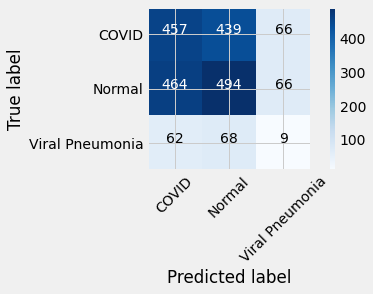

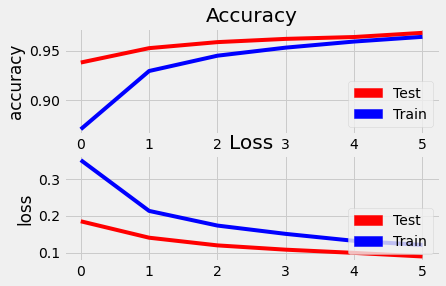

Epoch 7/100
532/532 [==============================] - 61s 114ms/step - loss: 0.1072 - accuracy: 0.9692 - f1_m: 0.9690 - precision_m: 0.9698 - recall_m: 0.9683 - val_loss: 0.0993 - val_accuracy: 0.9666 - val_f1_m: 0.9666 - val_precision_m: 0.9669 - val_recall_m: 0.9664

Epoch 00007: val_loss did not improve from 0.08983


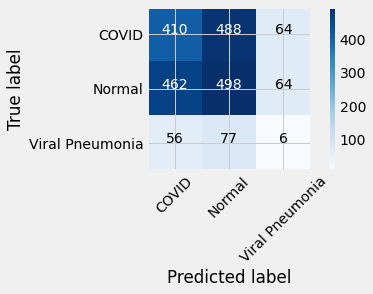

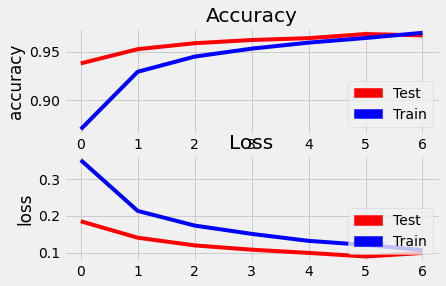

Epoch 8/100
532/532 [==============================] - 60s 113ms/step - loss: 0.0992 - accuracy: 0.9709 - f1_m: 0.9710 - precision_m: 0.9718 - recall_m: 0.9702 - val_loss: 0.0938 - val_accuracy: 0.9708 - val_f1_m: 0.9706 - val_precision_m: 0.9711 - val_recall_m: 0.9701

Epoch 00008: val_loss did not improve from 0.08983


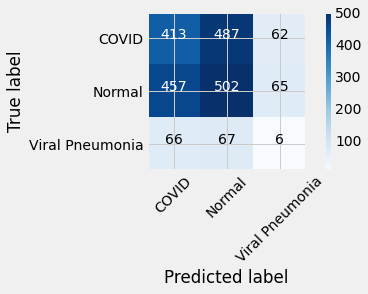

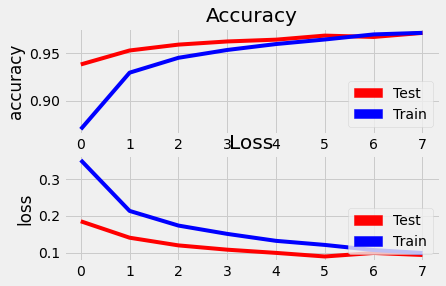

Epoch 9/100
532/532 [==============================] - 60s 114ms/step - loss: 0.0899 - accuracy: 0.9734 - f1_m: 0.9734 - precision_m: 0.9739 - recall_m: 0.9730 - val_loss: 0.0778 - val_accuracy: 0.9769 - val_f1_m: 0.9769 - val_precision_m: 0.9771 - val_recall_m: 0.9767

Epoch 00009: val_loss improved from 0.08983 to 0.07779, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


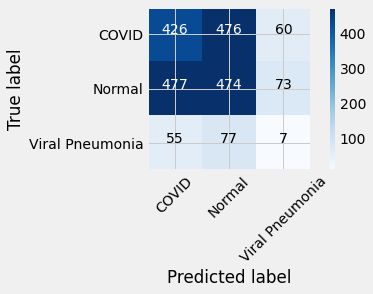

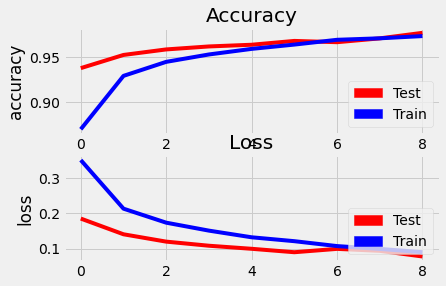

Epoch 10/100
532/532 [==============================] - 61s 114ms/step - loss: 0.0788 - accuracy: 0.9775 - f1_m: 0.9775 - precision_m: 0.9779 - recall_m: 0.9770 - val_loss: 0.0917 - val_accuracy: 0.9722 - val_f1_m: 0.9718 - val_precision_m: 0.9718 - val_recall_m: 0.9718

Epoch 00010: val_loss did not improve from 0.07779


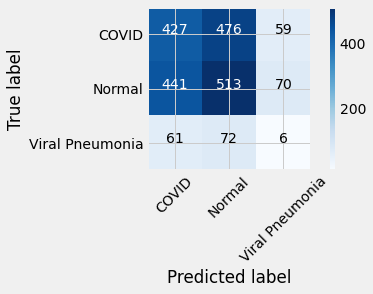

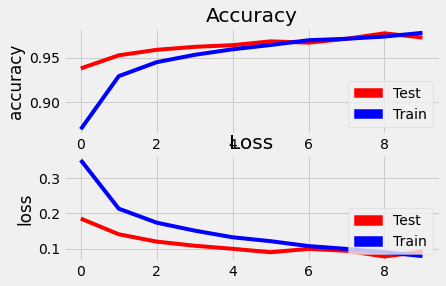

Epoch 11/100
532/532 [==============================] - 60s 114ms/step - loss: 0.0775 - accuracy: 0.9781 - f1_m: 0.9781 - precision_m: 0.9787 - recall_m: 0.9776 - val_loss: 0.0794 - val_accuracy: 0.9722 - val_f1_m: 0.9727 - val_precision_m: 0.9729 - val_recall_m: 0.9725

Epoch 00011: val_loss did not improve from 0.07779


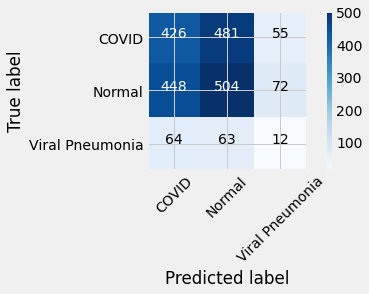

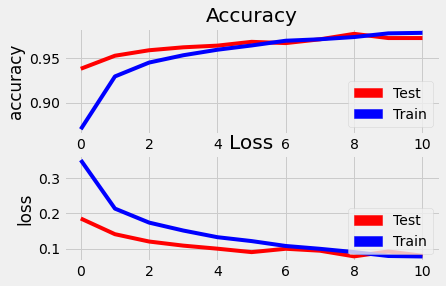

Epoch 12/100
532/532 [==============================] - 61s 115ms/step - loss: 0.0717 - accuracy: 0.9805 - f1_m: 0.9805 - precision_m: 0.9809 - recall_m: 0.9802 - val_loss: 0.0767 - val_accuracy: 0.9741 - val_f1_m: 0.9748 - val_precision_m: 0.9752 - val_recall_m: 0.9743

Epoch 00012: val_loss improved from 0.07779 to 0.07672, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


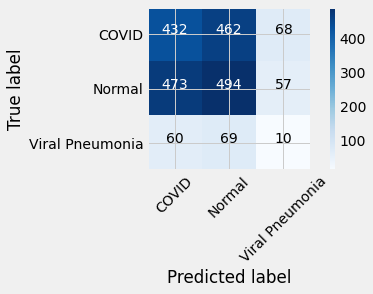

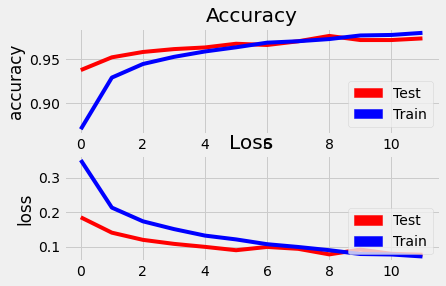

Epoch 13/100
532/532 [==============================] - 61s 114ms/step - loss: 0.0639 - accuracy: 0.9824 - f1_m: 0.9824 - precision_m: 0.9827 - recall_m: 0.9821 - val_loss: 0.0749 - val_accuracy: 0.9751 - val_f1_m: 0.9750 - val_precision_m: 0.9753 - val_recall_m: 0.9748

Epoch 00013: val_loss improved from 0.07672 to 0.07494, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


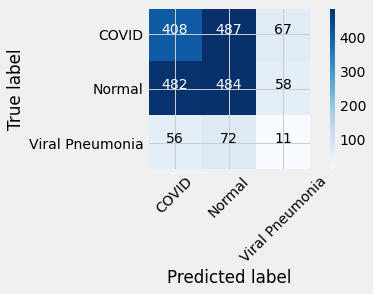

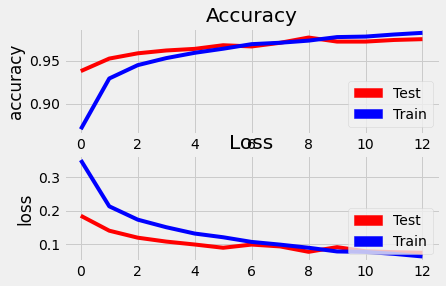

Epoch 14/100
532/532 [==============================] - 61s 115ms/step - loss: 0.0606 - accuracy: 0.9829 - f1_m: 0.9828 - precision_m: 0.9831 - recall_m: 0.9825 - val_loss: 0.0822 - val_accuracy: 0.9751 - val_f1_m: 0.9743 - val_precision_m: 0.9746 - val_recall_m: 0.9741

Epoch 00014: val_loss did not improve from 0.07494


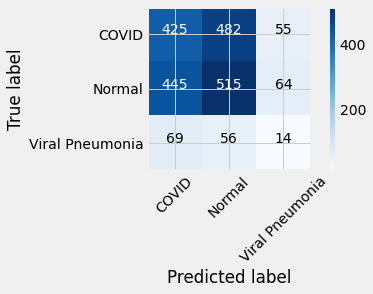

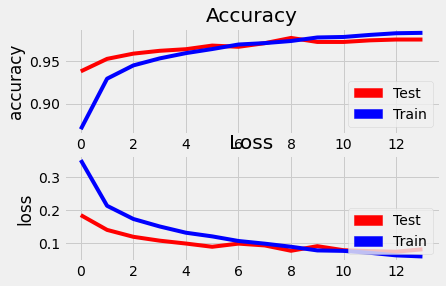

Epoch 15/100
532/532 [==============================] - 61s 115ms/step - loss: 0.0612 - accuracy: 0.9830 - f1_m: 0.9832 - precision_m: 0.9834 - recall_m: 0.9830 - val_loss: 0.0715 - val_accuracy: 0.9798 - val_f1_m: 0.9797 - val_precision_m: 0.9799 - val_recall_m: 0.9795

Epoch 00015: val_loss improved from 0.07494 to 0.07150, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


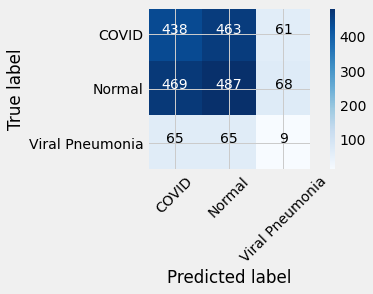

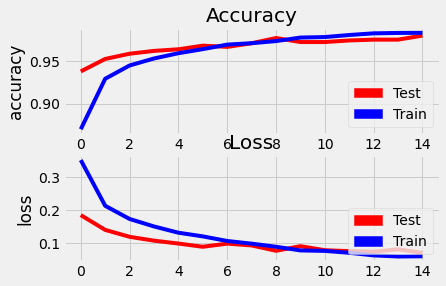

Epoch 16/100
532/532 [==============================] - 60s 113ms/step - loss: 0.0554 - accuracy: 0.9861 - f1_m: 0.9862 - precision_m: 0.9864 - recall_m: 0.9860 - val_loss: 0.0684 - val_accuracy: 0.9807 - val_f1_m: 0.9809 - val_precision_m: 0.9809 - val_recall_m: 0.9809

Epoch 00016: val_loss improved from 0.07150 to 0.06841, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


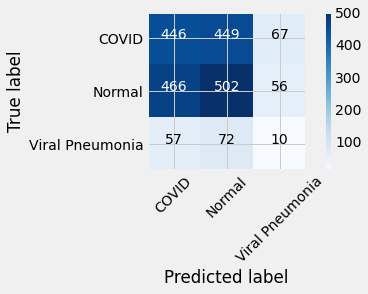

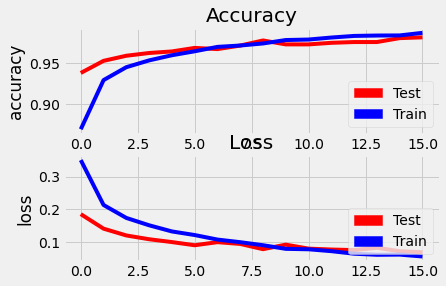

Epoch 17/100
532/532 [==============================] - 60s 113ms/step - loss: 0.0516 - accuracy: 0.9861 - f1_m: 0.9861 - precision_m: 0.9864 - recall_m: 0.9858 - val_loss: 0.0706 - val_accuracy: 0.9793 - val_f1_m: 0.9792 - val_precision_m: 0.9794 - val_recall_m: 0.9790

Epoch 00017: val_loss did not improve from 0.06841


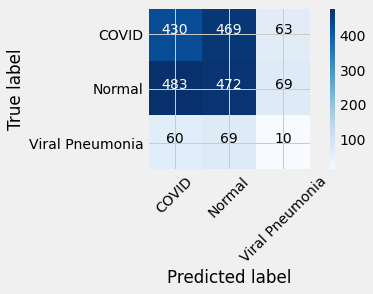

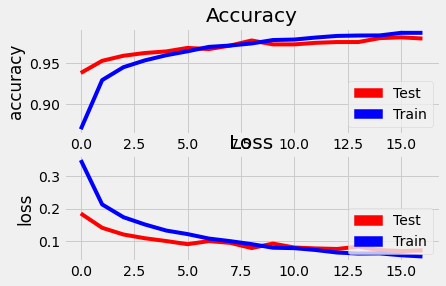

Epoch 18/100
532/532 [==============================] - 60s 113ms/step - loss: 0.0479 - accuracy: 0.9880 - f1_m: 0.9881 - precision_m: 0.9883 - recall_m: 0.9879 - val_loss: 0.0701 - val_accuracy: 0.9816 - val_f1_m: 0.9818 - val_precision_m: 0.9818 - val_recall_m: 0.9818

Epoch 00018: val_loss did not improve from 0.06841


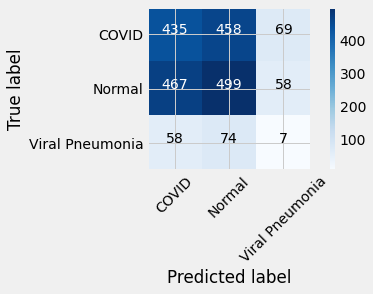

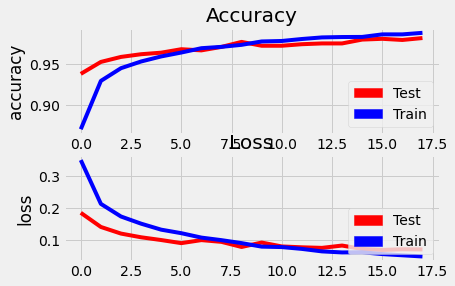

Epoch 19/100
532/532 [==============================] - 60s 112ms/step - loss: 0.0460 - accuracy: 0.9878 - f1_m: 0.9878 - precision_m: 0.9878 - recall_m: 0.9877 - val_loss: 0.0697 - val_accuracy: 0.9821 - val_f1_m: 0.9820 - val_precision_m: 0.9823 - val_recall_m: 0.9818

Epoch 00019: val_loss did not improve from 0.06841


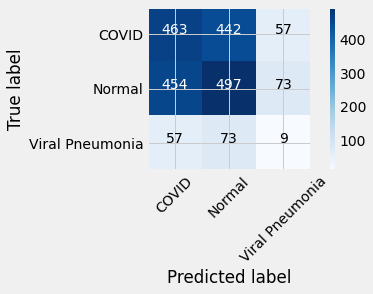

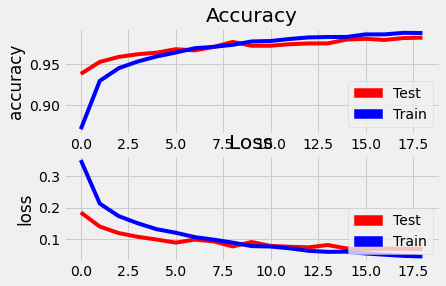

Epoch 20/100
532/532 [==============================] - 60s 113ms/step - loss: 0.0417 - accuracy: 0.9893 - f1_m: 0.9892 - precision_m: 0.9893 - recall_m: 0.9891 - val_loss: 0.0738 - val_accuracy: 0.9769 - val_f1_m: 0.9774 - val_precision_m: 0.9776 - val_recall_m: 0.9771

Epoch 00020: val_loss did not improve from 0.06841


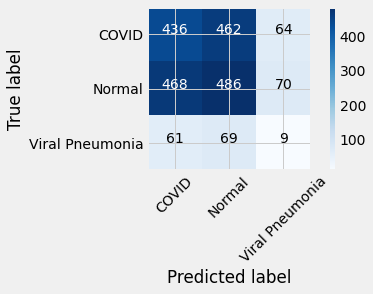

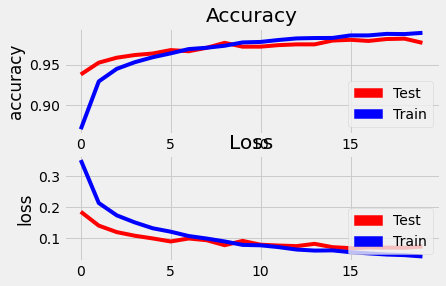

Epoch 21/100
532/532 [==============================] - 61s 114ms/step - loss: 0.0393 - accuracy: 0.9906 - f1_m: 0.9905 - precision_m: 0.9907 - recall_m: 0.9904 - val_loss: 0.0731 - val_accuracy: 0.9793 - val_f1_m: 0.9795 - val_precision_m: 0.9795 - val_recall_m: 0.9795

Epoch 00021: val_loss did not improve from 0.06841


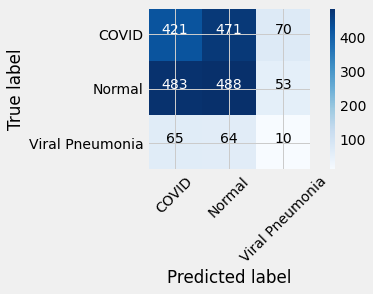

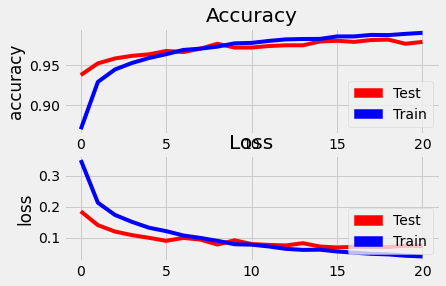

Trained


In [24]:
trained = train(model, train_generator, val_generator, toy)

# MODEL EVALUATION

## Generate Predictions

In [25]:
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = test.category.values
y_true=y_true[:len(y_pred)]

## Metrics Plot Functions

In [26]:
def plot_history(training):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].plot(training.history['loss'], label="Loss")
        ax[0].plot(training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(training.history['accuracy'], label="Accuracy")
        ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()

def train_report(training):
    print("------- Training Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['loss'])))

    print("------- Validation Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['val_accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['val_f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['val_precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['val_recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['val_loss'])))

def print_report():
    """
    Predict and evaluate using ground truth from labels
    Test generator did not shuffle 
    and we can use true labels for comparison
    """
    #Print classification report
    print(metrics.classification_report(y_true, y_pred.astype(str), target_names = labels))
    
def print_conf_mtx():
    
    cm = confusion_matrix(y_true.astype(int), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## Results

------- Training Report -----------
Accuracy: 96.89
F1 Score: 96.86
Precision: 97.01
Recall: 96.72
Loss: 0.10
------- Validation Report -----------
Accuracy: 97.07
F1 Score: 97.06
Precision: 97.10
Recall: 97.03
Loss: 0.09


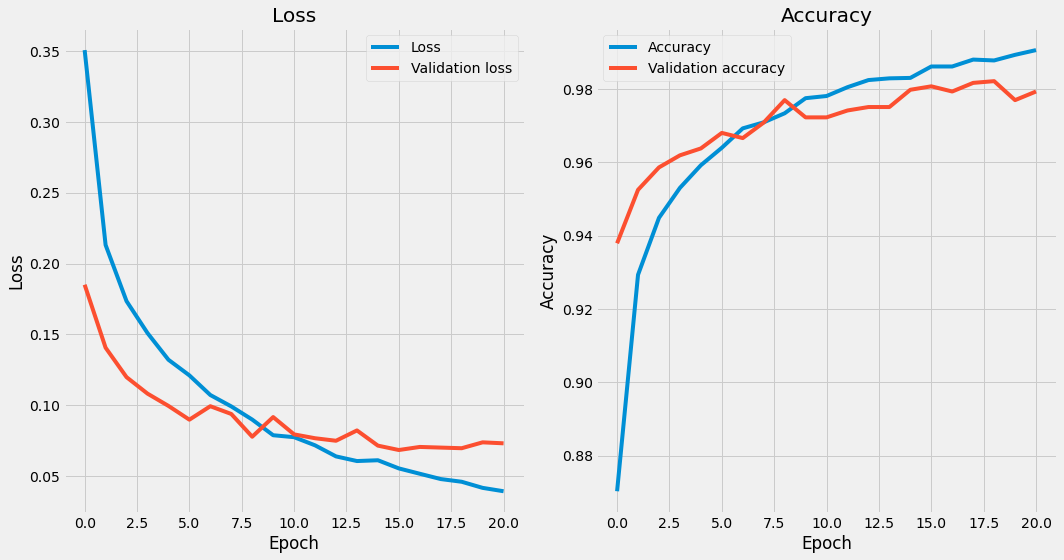

                 precision    recall  f1-score   support

          COVID       0.97      0.98      0.98       967
         Normal       0.98      0.97      0.98      1023
Viral Pneumonia       0.95      0.92      0.93       136

       accuracy                           0.97      2126
      macro avg       0.97      0.96      0.96      2126
   weighted avg       0.97      0.97      0.97      2126



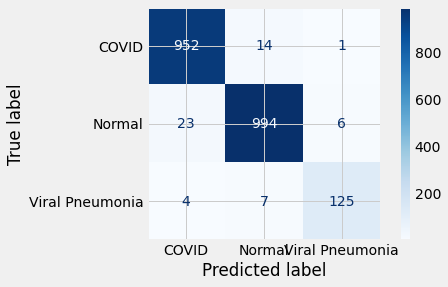

In [27]:
train_report(trained)
plot_history(trained)
print_report()
print_conf_mtx()